In [4]:
%run -i writefile2.py

In [7]:
%%writefile2

import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace as ns
import math
import require
get_oxford_categorical_flagged = require.single( "get_oxford_categorical_flagged" )

def get_data_for_country( country, categorical_as_dummy = True, verbose = True ):

    def plot_all( df, columns = None ):

        if columns is None:

            columns = df.columns

        n_cols = min( 4, len( columns ))
        n_rows = math.ceil( len( columns ) / 4 )
        fig, axs = plt.subplots( n_rows, n_cols, figsize = ( 4 * n_cols, 4 * n_rows ))

        if len( columns ) > 1:
        
            axs = axs.ravel( )
            
        fig.subplots_adjust( hspace = 0.5 )
        
        for i, c in enumerate( columns ):
        
            df[ c ].plot( title = c.replace( '_', ' ' ), ax = axs[ i ])

        #remove unwanted grid cells
        if n_rows > 1:

            for ax in axs[ -(( n_cols * n_rows ) - len( columns )) : ]:

                ax.remove( )

        plt.show( )
    
    if verbose:

        display( HTML( f"<h1>{ country }</h1>" ))
    
    df = pd.read_csv( "data/owid-covid-data.csv", index_col = "date", parse_dates = True, low_memory = False )
    df = df[ df.location == country ]

    # outcomes

    columns = [ "new_cases_smoothed_per_million", "new_deaths_smoothed_per_million", "weekly_hosp_admissions_per_million" ]
    outcome_df = df[ columns ].copy( )

    for c in columns:

        pass
        #outcome_df[ np.isnan( outcome_df[ c ])] = 0

    if verbose:

        display( HTML( f"<h3>outcomes</h3>" ))
        plot_all( outcome_df )

    # OWID measures

    columns = [ "new_vaccinations_smoothed_per_million", "new_tests_smoothed_per_thousand" ]
    measure_df = df[ columns ].copy( )

    for c in columns:

        measure_df[ c ][ np.isnan( measure_df[ c ])] = 0

    # Oxford measures

    indicators = [ 
    
        ns( name = "c6m_stay_at_home_requirements", range = np.arange( 4. )), 
        ns( name = "c8ev_internationaltravel", range = np.arange( 5. )), 
        ns( name = "h6m_facial_coverings", range = np.arange( 5. )), 
        ns( name = "c4m_restrictions_on_gatherings", range = np.arange( 5. )) 
    ]
    
    dummy_series_per_indicator = { 
        indicator.name: get_oxford_categorical_flagged( 
            country, indicator.name, 
            verbose = False, 
            use_dummies = categorical_as_dummy 
        ) for indicator in indicators }

    for indicator in indicators:

        dummy_series = dummy_series_per_indicator[ indicator.name ]
        date_offset = 2 # oxford data starts 2 days earlier, just discard it

        if categorical_as_dummy:
        
            for value in [ v for v in indicator.range if v != 0 ]:
        
                key = f"{ value }"
                column = f"{ indicator.name }=={ value }"
                
                if key in dummy_series:
        
                    measure_df[ column ] = dummy_series[ key ][ date_offset: ]
                    assert measure_df.index[ 0 ] == dummy_series[ key ].index[ date_offset ]
        
                else:
        
                    measure_df[ column ] = 0

        else:

            measure_df[ indicator.name ] = dummy_series[ date_offset: ]

    if verbose:

        url = "https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies"
        display( HTML( f"<h3>measures</h3><p><a href={ url }>see here</a> for an explanation of categorical values</p>" ))
        plot_all( measure_df )

    full_df = pd.concat([ outcome_df, measure_df ], axis = 1 )
    return full_df


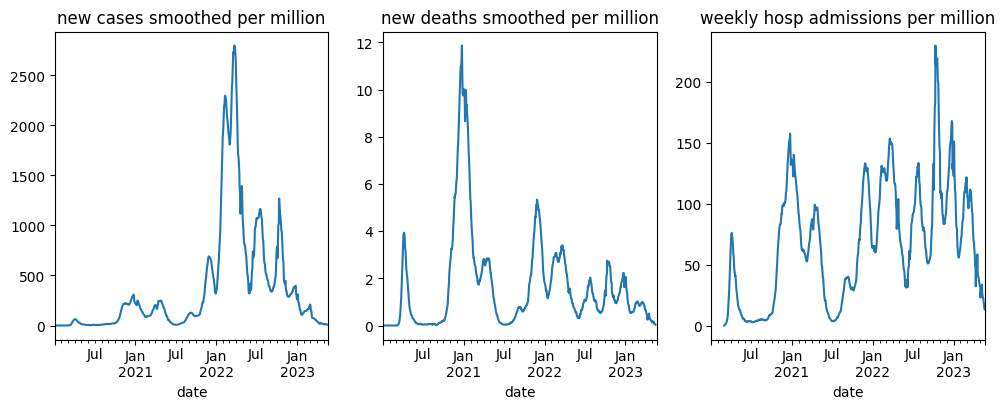

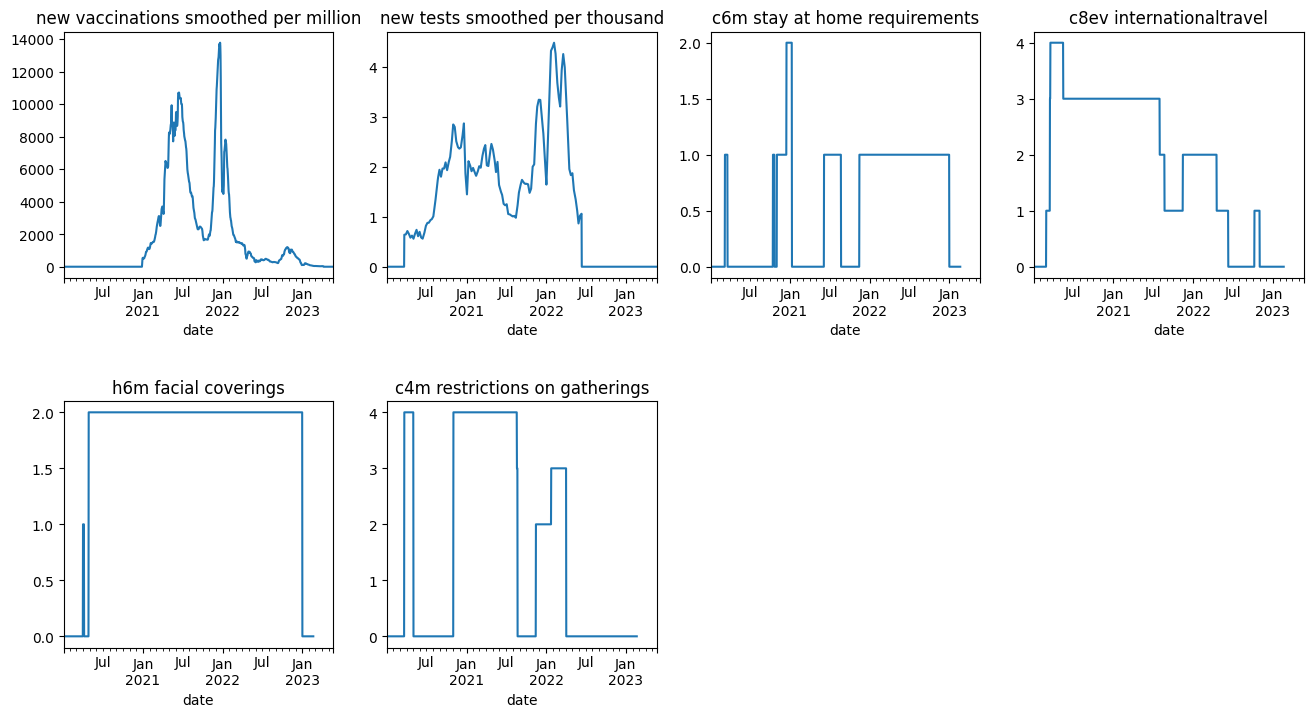

In [10]:
country_df = get_data_for_country( "Germany", categorical_as_dummy = False )

In [11]:
country_df.columns

Index(['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
       'weekly_hosp_admissions_per_million',
       'new_vaccinations_smoothed_per_million',
       'new_tests_smoothed_per_thousand', 'c6m_stay_at_home_requirements',
       'c8ev_internationaltravel', 'h6m_facial_coverings',
       'c4m_restrictions_on_gatherings'],
      dtype='object')